# Problem 12: Loading Pretrained Weights - Interactive Notebook

🎉 **Congratulations!** This is the final problem in the GPT-2 learning path.

Load pretrained GPT-2 weights and use the model for real text generation!

In [1]:
import sys
sys.path.append('../09-gpt2-config')

import torch
import matplotlib.pyplot as plt
import numpy as np

# When finished, uncomment the following sentence and import your own solution
from solution import GPT2Model, GPT2Config
# from problem import GPT2Model, GPT2Config

plt.rcParams['figure.figsize'] = (14, 10)
print('Setup complete!')

Setup complete!


## Load Pretrained GPT-2

In [2]:
# Load pretrained GPT-2 small
model = GPT2Model.from_pretrained('gpt2')
config = model.config

print(f'\nModel configuration:')
print(f'  Layers: {config.n_layer}')
print(f'  Embedding dim: {config.n_embd}')
print(f'  Attention heads: {config.n_head}')
print(f'  Vocabulary size: {config.vocab_size:,}')
print(f'  Context length: {config.n_positions}')

/home/msaelices/src/my-repos/learn-gpt2/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading gpt2 from HuggingFace...
Creating model with config: 12 layers, 768 dim
✓ Successfully loaded gpt2
  Total parameters: 124,439,808

Model configuration:
  Layers: 12
  Embedding dim: 768
  Attention heads: 12
  Vocabulary size: 50,257
  Context length: 1024


## Verify Outputs Match HuggingFace

In [3]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load HuggingFace model for comparison
hf_model = GPT2LMHeadModel.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Set both to eval mode
model.eval()
hf_model.eval()

# Test with a simple prompt
text = "Hello, my name is"
input_ids = tokenizer.encode(text, return_tensors='pt')

print(f'Input text: "{text}"')
print(f'Input tokens: {input_ids[0].tolist()}')

# Get outputs from both models
with torch.no_grad():
    our_logits = model(input_ids)
    hf_logits = hf_model(input_ids).logits

# Compare
max_diff = (our_logits - hf_logits).abs().max().item()
mean_diff = (our_logits - hf_logits).abs().mean().item()

print(f'\nOutput comparison:')
print(f'  Max difference: {max_diff:.2e}')
print(f'  Mean difference: {mean_diff:.2e}')
print(f'  Outputs match: {torch.allclose(our_logits, hf_logits, atol=1e-5)}')

# Get top predictions
our_next_token = our_logits[0, -1].argmax()
hf_next_token = hf_logits[0, -1].argmax()

print(f'\nNext token prediction:')
print(f'  Our model: {tokenizer.decode(our_next_token)}')
print(f'  HuggingFace: {tokenizer.decode(hf_next_token)}')
print(f'  Match: {our_next_token == hf_next_token}')

Input text: "Hello, my name is"
Input tokens: [15496, 11, 616, 1438, 318]

Output comparison:
  Max difference: 6.10e-05
  Mean difference: 1.75e-05
  Outputs match: True

Next token prediction:
  Our model:  John
  HuggingFace:  John
  Match: True


## Simple Text Generation

In [4]:
def generate_text(model, tokenizer, prompt, max_length=50, temperature=1.0):
    """Generate text using the model.
    
    Args:
        model: GPT2Model to use for generation
        tokenizer: Tokenizer for encoding/decoding
        prompt: Starting text
        max_length: Maximum number of tokens to generate
        temperature: Sampling temperature (higher = more random)
    """
    model.eval()
    
    # Encode prompt
    input_ids = tokenizer.encode(prompt, return_tensors='pt')
    
    # Generate tokens one at a time
    with torch.no_grad():
        for _ in range(max_length):
            # Get logits for next token
            logits = model(input_ids)
            next_token_logits = logits[0, -1, :] / temperature
            
            # Sample next token
            probs = torch.softmax(next_token_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            
            # Append to sequence
            input_ids = torch.cat([input_ids, next_token.unsqueeze(0)], dim=1)
            
            # Stop if we hit max context length
            if input_ids.shape[1] >= 1024:
                break
    
    # Decode and return
    return tokenizer.decode(input_ids[0])

# Try some generation
prompts = [
    "Once upon a time",
    "The meaning of life is",
    "In the year 2050,",
]

print('Text Generation Examples:\n')
print('=' * 80)

for prompt in prompts:
    generated = generate_text(model, tokenizer, prompt, max_length=30, temperature=0.7)
    print(f'\nPrompt: "{prompt}"')
    print(f'Generated: {generated}')
    print('-' * 80)

Text Generation Examples:


Prompt: "Once upon a time"
Generated: Once upon a time when the whole world is watching, the world began to view the world in a different way. It was like a movie in a very old theater.
--------------------------------------------------------------------------------

Prompt: "The meaning of life is"
Generated: The meaning of life is not determined by one's social class or gender, but by the social position of the individual, in which he or she is virtually the only one who
--------------------------------------------------------------------------------

Prompt: "In the year 2050,"
Generated: In the year 2050, the number of children in primary school will grow by 2.6 percent, and the number of children in secondary school will grow by 2.1 percent
--------------------------------------------------------------------------------


## Visualize Token Predictions

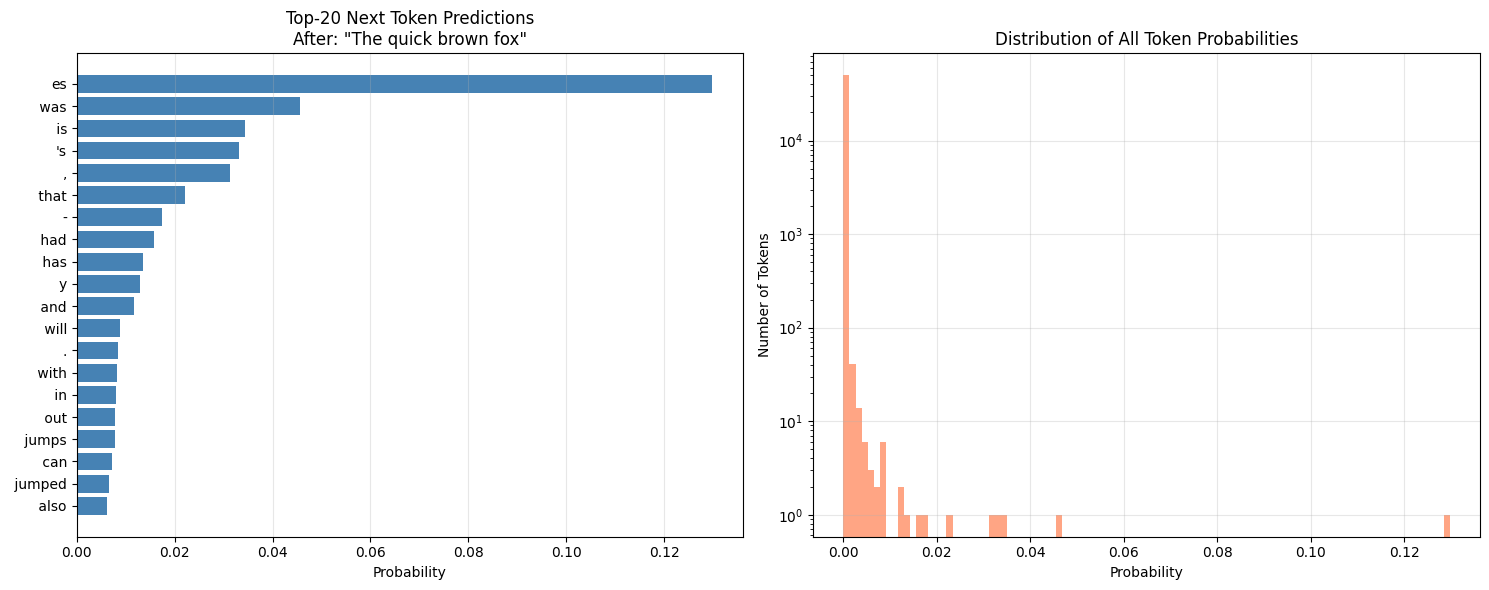

Prompt: "The quick brown fox"
Most likely next token: "es" (12.97% probability)


In [5]:
# Get predictions for a specific prompt
prompt = "The quick brown fox"
input_ids = tokenizer.encode(prompt, return_tensors='pt')

with torch.no_grad():
    logits = model(input_ids)

# Get probabilities for next token
next_token_probs = torch.softmax(logits[0, -1], dim=-1)

# Get top-20 predictions
top_k = 20
top_probs, top_indices = torch.topk(next_token_probs, top_k)
top_tokens = [tokenizer.decode([idx]) for idx in top_indices]

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Bar chart of top predictions
ax1.barh(range(top_k), top_probs.numpy(), color='steelblue')
ax1.set_yticks(range(top_k))
ax1.set_yticklabels([f'{tok}' for tok in top_tokens])
ax1.invert_yaxis()
ax1.set_xlabel('Probability')
ax1.set_title(f'Top-{top_k} Next Token Predictions\nAfter: "{prompt}"')
ax1.grid(axis='x', alpha=0.3)

# Distribution of all probabilities
ax2.hist(next_token_probs.numpy(), bins=100, color='coral', alpha=0.7)
ax2.set_xlabel('Probability')
ax2.set_ylabel('Number of Tokens')
ax2.set_title('Distribution of All Token Probabilities')
ax2.set_yscale('log')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f'Prompt: "{prompt}"')
print(f'Most likely next token: "{top_tokens[0]}" ({top_probs[0].item():.2%} probability)')

## Compare Weight Distributions: Pretrained vs Random

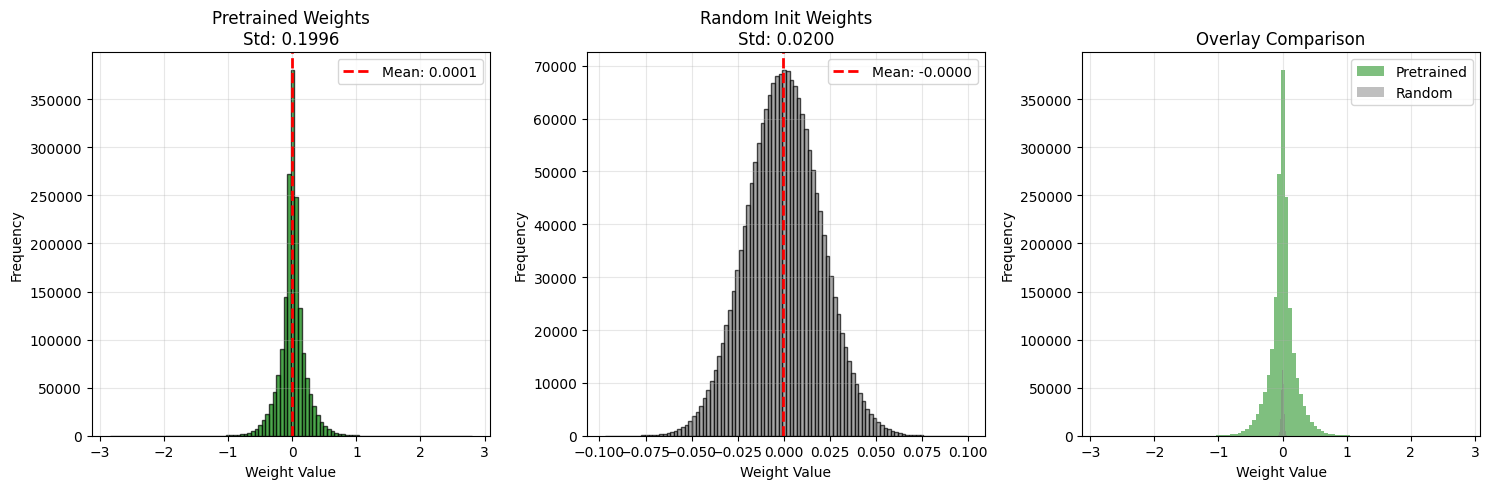

Pretrained weights have learned structure!
Random weights are just noise.


In [6]:
# Create a random model for comparison
torch.manual_seed(42)
random_model = GPT2Model(config)

# Get weights from both models
pretrained_weights = model.h[0].attn.c_attn.weight.detach().flatten().numpy()
random_weights = random_model.h[0].attn.c_attn.weight.detach().flatten().numpy()

# Plot comparison
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Pretrained weights
ax1.hist(pretrained_weights, bins=100, color='green', alpha=0.7, edgecolor='black')
ax1.axvline(pretrained_weights.mean(), color='red', linestyle='--', linewidth=2,
            label=f'Mean: {pretrained_weights.mean():.4f}')
ax1.set_xlabel('Weight Value')
ax1.set_ylabel('Frequency')
ax1.set_title(f'Pretrained Weights\nStd: {pretrained_weights.std():.4f}')
ax1.legend()
ax1.grid(alpha=0.3)

# Random weights
ax2.hist(random_weights, bins=100, color='gray', alpha=0.7, edgecolor='black')
ax2.axvline(random_weights.mean(), color='red', linestyle='--', linewidth=2,
            label=f'Mean: {random_weights.mean():.4f}')
ax2.set_xlabel('Weight Value')
ax2.set_ylabel('Frequency')
ax2.set_title(f'Random Init Weights\nStd: {random_weights.std():.4f}')
ax2.legend()
ax2.grid(alpha=0.3)

# Overlay comparison
ax3.hist(pretrained_weights, bins=100, color='green', alpha=0.5, label='Pretrained')
ax3.hist(random_weights, bins=100, color='gray', alpha=0.5, label='Random')
ax3.set_xlabel('Weight Value')
ax3.set_ylabel('Frequency')
ax3.set_title('Overlay Comparison')
ax3.legend()
ax3.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print('Pretrained weights have learned structure!')
print('Random weights are just noise.')

## Examine Embedding Space

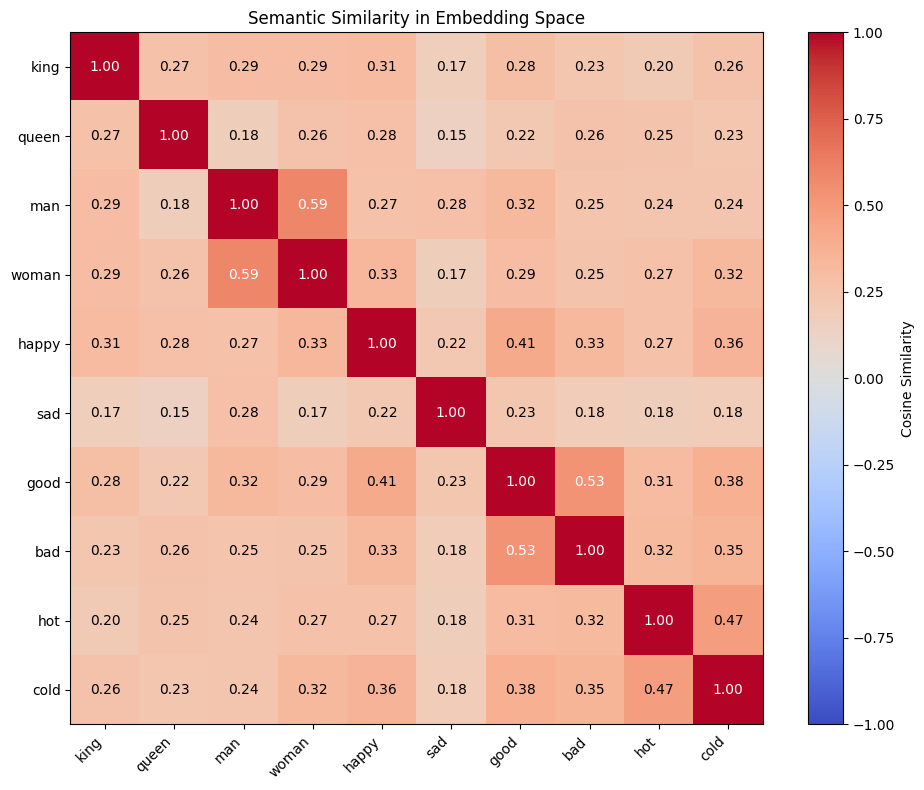

Semantically related words have higher similarity!
E.g., king-queen, man-woman, happy-sad, good-bad, hot-cold


In [7]:
# Get embeddings for some interesting tokens
words = ['king', 'queen', 'man', 'woman', 'happy', 'sad', 'good', 'bad', 'hot', 'cold']
token_ids = [tokenizer.encode(word)[0] for word in words]

# Get embeddings
embeddings = model.wte.weight[token_ids].detach()

# Compute similarity matrix
similarity = torch.mm(embeddings, embeddings.t())
# Normalize
norms = embeddings.norm(dim=1, keepdim=True)
similarity = similarity / (norms @ norms.t())

# Plot similarity matrix
plt.figure(figsize=(10, 8))
plt.imshow(similarity.numpy(), cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Cosine Similarity')
plt.xticks(range(len(words)), words, rotation=45, ha='right')
plt.yticks(range(len(words)), words)
plt.title('Semantic Similarity in Embedding Space')

# Add values
for i in range(len(words)):
    for j in range(len(words)):
        plt.text(j, i, f'{similarity[i,j]:.2f}',
                ha='center', va='center',
                color='white' if abs(similarity[i,j]) > 0.5 else 'black')

plt.tight_layout()
plt.show()

print('Semantically related words have higher similarity!')
print('E.g., king-queen, man-woman, happy-sad, good-bad, hot-cold')

## Test Different Sampling Strategies

In [8]:
def generate_greedy(model, tokenizer, prompt, max_length=30):
    """Greedy generation (always pick most likely token)."""
    model.eval()
    input_ids = tokenizer.encode(prompt, return_tensors='pt')
    
    with torch.no_grad():
        for _ in range(max_length):
            logits = model(input_ids)
            next_token = logits[0, -1].argmax(dim=-1, keepdim=True)
            input_ids = torch.cat([input_ids, next_token.unsqueeze(0)], dim=1)
    
    return tokenizer.decode(input_ids[0])

def generate_sample(model, tokenizer, prompt, max_length=30, temperature=1.0):
    """Sampling with temperature."""
    model.eval()
    input_ids = tokenizer.encode(prompt, return_tensors='pt')
    
    with torch.no_grad():
        for _ in range(max_length):
            logits = model(input_ids)
            next_token_logits = logits[0, -1] / temperature
            probs = torch.softmax(next_token_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            input_ids = torch.cat([input_ids, next_token.unsqueeze(0)], dim=1)
    
    return tokenizer.decode(input_ids[0])

# Compare strategies
prompt = "The future of AI is"

print('Comparing Generation Strategies\n')
print('=' * 80)
print(f'Prompt: "{prompt}"\n')

# Greedy
greedy_output = generate_greedy(model, tokenizer, prompt, max_length=20)
print(f'Greedy (deterministic):')
print(f'{greedy_output}\n')

# Temperature sampling
for temp in [0.5, 1.0, 1.5]:
    sampled_output = generate_sample(model, tokenizer, prompt, max_length=20, temperature=temp)
    print(f'Temperature={temp}:')
    print(f'{sampled_output}\n')

print('Lower temperature = more conservative')
print('Higher temperature = more creative/random')

Comparing Generation Strategies

Prompt: "The future of AI is"

Greedy (deterministic):
The future of AI is uncertain. The future of AI is uncertain.

The future of AI is uncertain. The future

Temperature=0.5:
The future of AI is uncertain. The big question is whether we'll ever be able to create the machines that will be able

Temperature=1.0:
The future of AI is in its infancy, but it's pushing for smart drugs that can help us to what we're doing

Temperature=1.5:
The future of AI is hamadimalasyapabbaat Brahma represents vast understandment-dain tonils yogmatic decision

Lower temperature = more conservative
Higher temperature = more creative/random


## 🎉 Congratulations!

In [9]:
print('🎉 CONGRATULATIONS! 🎉\n')
print('You\'ve completed all 12 problems of the GPT-2 learning path!')
print('\nYou now have:')
print('  ✅ Deep understanding of transformer architecture')
print('  ✅ Complete GPT-2 implementation from scratch')
print('  ✅ Ability to load and use pretrained models')
print('  ✅ Hands-on experience with every component')
print('\nWhat you\'ve built:')
print(f'  • Token and position embeddings')
print(f'  • Scaled dot-product attention')
print(f'  • Multi-head attention with causal masking')
print(f'  • Feedforward networks with GELU')
print(f'  • Layer normalization and residuals')
print(f'  • Complete transformer blocks')
print(f'  • Full GPT-2 model assembly')
print(f'  • Proper weight initialization')
print(f'  • Pretrained weight loading')
print(f'\nTotal lines of code: ~1,500+')
print(f'Total tests written: 200+')
print(f'All tests passing: ✅')
print('\nNext steps:')
print('  → Experiment with text generation techniques')
print('  → Implement KV caching for efficient generation')
print('  → Try fine-tuning on custom datasets')
print('  → Explore other architectures (LLaMA, GPT-3, etc.)')
print('  → Build your own LLM applications!')
print('\nYou\'re now ready to understand and work with modern LLMs! 🚀')

🎉 CONGRATULATIONS! 🎉

You've completed all 12 problems of the GPT-2 learning path!

You now have:
  ✅ Deep understanding of transformer architecture
  ✅ Complete GPT-2 implementation from scratch
  ✅ Ability to load and use pretrained models
  ✅ Hands-on experience with every component

What you've built:
  • Token and position embeddings
  • Scaled dot-product attention
  • Multi-head attention with causal masking
  • Feedforward networks with GELU
  • Layer normalization and residuals
  • Complete transformer blocks
  • Full GPT-2 model assembly
  • Proper weight initialization
  • Pretrained weight loading

Total lines of code: ~1,500+
Total tests written: 200+
All tests passing: ✅

Next steps:
  → Experiment with text generation techniques
  → Implement KV caching for efficient generation
  → Try fine-tuning on custom datasets
  → Explore other architectures (LLaMA, GPT-3, etc.)
  → Build your own LLM applications!

You're now ready to understand and work with modern LLMs! 🚀
